In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
import io
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from PIL import Image
import cv2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

from sentence_transformers import SentenceTransformer
lang_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)
                
# helper mlp init function
def mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# MLP policy
class MLPPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)

# MLP policy
class CNNPolicy(nn.Module):
    def __init__(
        self, goal_dim, action_dim, hidden_size, mask=False, output_mod=None):
        super().__init__()
        self.mask = mask
        self.goal = mlp(goal_dim, hidden_size, hidden_dim=0, hidden_depth=0, output_mod=None) # => hidden_size
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=8,stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32,64,kernel_size=4,stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64,32,kernel_size=3,stride=1), nn.LeakyReLU(inplace=True), Flatten(), nn.BatchNorm1d(32), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, hidden_size) #(b_size,32*1*1)=>(b_size,hidden_size)
        )
        self.process = mlp(hidden_size*2, 1*36*36, hidden_dim=1000, hidden_depth=1, output_mod=nn.Sigmoid()) #(b_size,hidden_size*2)=>(b_size,32*1*1)
        # UNet deconv mask --------------------------------------------------------------------------------------------------
        #self.deconv = nn.Sequential(
        #    nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32*1*1)=>(b_size,64,3,3)
        #    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,64,3,3)=>(b_size,32,8,8)
        #    nn.ConvTranspose2d(32, 1, kernel_size=8, stride=4), nn.Sigmoid(), #(b_size,32,8,8)=>(b_size,3,36,36)
        #)
        self.cnntrunk = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), Flatten(), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, action_dim)#, nn.LeakyReLU(inplace=True), nn.BatchNorm1d(32), #(b_size,32*1*1)=>(b_size,hidden_size)
            #nn.Linear(32, action_dim) #(b_size,hidden_size)=>(b_size,action_dim)
        )
        self.mlptrunk = mlp(hidden_size*2, action_dim, hidden_dim=100, hidden_depth=1) #(b_size,hidden_size*2)=>(b_size,action_dim)
        self.apply(weight_init)

    def forward(self, goal, state, gt_mask):
        state = state/255.0 # process image + switch channels
        state = state.permute(0,3,1,2)
        state_embed = self.conv(state)
        goal_embed = self.goal(goal) # process goal
        goal_state = torch.cat((goal_embed,state_embed),dim=1) # process goal + state
        
        if self.mask:
            img_mask = self.process(goal_state)
            img_mask = img_mask.reshape(-1,1,36,36)
            #img_mask = img_mask.reshape(-1,32,1,1)
            #img_mask = self.deconv(img_mask) # deconv for mask
            #--------------------- test with gt mask
            #img_mask = gt_mask.reshape((-1, 36, 36, 1)) # reshape to 1 channel
            #img_mask = np.repeat(img_mask, 3, axis=3) # duplicate across 3 channels
            #img_mask = img_mask.permute(0,3,1,2) # process channel switch
            #---------------------
            masked_state = state * img_mask # apply mask to full state
            pred = self.cnntrunk(masked_state)
            return [pred, masked_state, img_mask]
        else:
            pred = self.mlptrunk(goal_state)
            return [pred]

In [3]:
# Goal-conditioned Point Maze (with multi state + color)
import gym
import gym.wrappers

class PointEnvGrid(gym.Env):
    def __init__(self):
        self.pos = np.array([99., 99.])
        self.obj1_pos = np.array([99., 99.])
        self.obj1_color = np.array([99., 99., 99., 99.])
        self.obj1_shape = np.array([99., 99., 99., 99.])
        self.obj2_pos = np.array([99., 99.])
        self.obj2_color = np.array([99., 99., 99., 99.])
        self.obj2_shape = np.array([99., 99., 99., 99.])
        self.goal = np.array(['go to the red X'])
        self.goal_pos = np.array([99., 99.])
        self.goal_color = np.array([99., 99., 99., 99.])
        self.goal_shape = np.array([99., 99., 99., 99.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(14), np.inf * np.ones(14)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    # creates test env with defined goal locations + colors
    def reset(self, agent_pos=[0,1,2,3], obj_pos=[0,1,2,3], obj_colors=[0,1,2,3], obj_shapes=[0,1,2,3], scalar=5):
        # generates agent+objs without overlap
        agent_loc = np.random.choice(agent_pos)
        obj_pos = copy.deepcopy(obj_pos)
        if agent_loc in obj_pos:
            obj_pos.remove(agent_loc)
        self.pos = self.gen_pos(agent_loc, scalar)
        
        obj1_loc, obj2_loc = random.sample(obj_pos, 2)
        self.obj1_pos = self.gen_pos(obj1_loc, scalar)
        self.obj1_color = self.gen_color(obj_colors)
        self.obj1_shape = self.gen_shape(obj_shapes)
        self.obj2_pos = self.gen_pos(obj2_loc, scalar)
        self.obj2_color = self.gen_color(obj_colors)
        self.obj2_shape = self.gen_shape(obj_shapes)

        # choose goal from random in objects
        goal_obj = random.randint(1, 2)
        if goal_obj == 1:
            self.goal_pos = self.obj1_pos
            self.goal_color = self.obj1_color
            self.goal_shape = self.obj1_shape
        elif goal_obj == 2:
            self.goal_pos = self.obj2_pos
            self.goal_color = self.obj2_color
            self.goal_shape = self.obj2_shape
        self.goal = np.array(['go to the ' + get_color(self.goal_color) + ' ' + get_shape(self.goal_shape)])
        return self.get_full_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj1_shape, self.obj2_pos, self.obj2_color, self.obj2_shape, self.goal_color, self.goal_shape]))
    
    def get_full_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj1_shape, self.obj2_pos, self.obj2_color, self.obj2_shape, self.goal_pos, self.goal_color, self.goal_shape]))
    
    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_full_obs(), reward, False, {}

    # given a range of areas, randomly selects and generates position
    def gen_pos(self, location, scalar):
        if location == 0:
            pos = np.array([-1.*scalar, 1.*scalar])
        elif location == 1:
            pos = np.array([1.*scalar, 1.*scalar])
        elif location == 2:
            pos = np.array([1.*scalar, -1.*scalar])
        elif location == 3:
            pos = np.array([-1.*scalar, -1.*scalar])
        return pos

    def gen_color(self, colors):
        one_hot_color = np.zeros(shape=4) # defines total number of colors to choose from
        rand_color = random.choice(colors) # samples color from range
        one_hot_color[rand_color] = 1.
        return one_hot_color

    def gen_shape(self, shapes):
        one_hot_shape = np.zeros(shape=4)
        rand_shape = random.choice(shapes)
        one_hot_shape[rand_shape] = 1.
        return one_hot_shape

class PointEnvComplex(gym.Env):
    def __init__(self):
        self.pos = np.array([99., 99.])
        self.obj1_pos = np.array([99., 99.])
        self.obj1_color = np.array([99., 99., 99.])
        self.obj2_pos = np.array([99., 99.])
        self.obj2_color = np.array([99., 99., 99.])
        self.goal = np.array(['go to the red star'])
        self.goal_pos = np.array([99., 99.])
        self.goal_color = np.array([99., 99., 99.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(14), np.inf * np.ones(14)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    # creates test env with defined goal locations + colors
    def reset(self, obj_angles=360, obj_colors=[0,1,2], discretize=10):
        self.pos = np.array([0., 0.])
        self.obj1_pos, self.obj1_color = self.gen_obj(obj_angles, obj_colors, discretize)
        self.obj2_pos, self.obj2_color = self.gen_obj(obj_angles, obj_colors, discretize)

        # choose goal from random in objects
        goal_obj = random.randint(1, 2)
        if goal_obj == 1:
            self.goal_pos = self.obj1_pos
            self.goal_color = self.obj1_color
        elif goal_obj == 2:
            self.goal_pos = self.obj2_pos
            self.goal_color = self.obj2_color
        self.goal = np.array(['go to the ' + get_color(self.goal_color) + ' square'])
        return self.get_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.goal_color]))
    
    def get_full_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.goal_pos, self.goal_color]))
    
    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_full_obs(), reward, False, {}

    # function to generate object based on angles, colors, and discretization ranges
    def gen_obj(self, obj_angles, obj_colors, discretize):
        angle = np.random.uniform(0, obj_angles) # samples angle from range
        angle = round(angle/discretize)*discretize # discretizes to defined range (default 10)
        pos = np.array([5*np.cos(np.deg2rad(angle)), 5*np.sin(np.deg2rad(angle))]) # maps to unit circle
        
        color = np.zeros(shape = 3) # defines total number of colors to choose from
        rand_color = random.sample(obj_colors,1) # samples color from range
        color[rand_color] = 1.
        return pos, color

def get_color(color):
    if color[0] == 1.:
        return 'red'
    elif color[1] == 1.:
        return 'green'
    elif color[2] == 1.:
        return 'blue'
    elif color[3] == 1.:
        return 'yellow'

def get_shape(shape):
    if shape[0] == 1.:
        return 'X'
    elif shape[1] == 1.:
        return 's'
    elif shape[2] == 1.:
        return '^'
    elif shape[3] == 1.:
        return 'd'

In [13]:
def plot_env(env):
    fig = plt.figure(figsize=(5, 5),facecolor="black")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.axis('off')
    plt.scatter(env.pos[0],env.pos[1], marker='o', color='white', s=500) # plots agent
    plt.scatter(env.obj1_pos[0], env.obj1_pos[1], marker=get_shape(env.obj1_shape), color=get_color(env.obj1_color), s=500) # plots obj1
    plt.scatter(env.obj2_pos[0], env.obj2_pos[1], marker=get_shape(env.obj2_shape), color=get_color(env.obj2_color), s=500) # plots obj2
    #plt.scatter(env.goal_pos[0], env.goal_pos[1], marker=get_shape(env.goal_shape), color=get_color(env.goal_color), s=1000) # plots goal
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = data.reshape((int(h), int(w), -1))
    img = img[:,:,:3]
    plt.close()
    return img

def plot_full_state(state):
    fig = plt.figure(figsize=(.5, .5),facecolor="black")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.axis('off')
    plt.scatter(state[0], state[1], marker='o', color='white', s=10) # plots agent
    plt.scatter(state[2], state[3], marker=get_shape(state[8:12]), color=get_color(state[4:8]), s=10) # plots obj1
    plt.scatter(state[12], state[13], marker=get_shape(state[18:22]), color=get_color(state[14:18]), s=10) # plots obj1
    #plt.scatter(state[22], state[23], marker=get_shape(28:32), color=get_color(state[24:28]), s=15) # plots goal
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = data.reshape((int(h), int(w), -1))
    img = img[:,:,:3]
    plt.close()
    return img

def plot_img_mask(state):
    fig = plt.figure(figsize=(.5, .5),facecolor="black")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.axis('off')
    #plt.scatter(state[0], state[1], marker='o', color='white', s=10) # plots agent
    #plt.scatter(state[2], state[3], marker=get_shape(state[8:12]), color=get_color(state[4:8]), s=10) # plots obj1
    #plt.scatter(state[12], state[13], marker=get_shape(state[18:22]), color=get_color(state[14:18]), s=10) # plots obj1
    plt.scatter(state[22], state[23], marker=get_shape(state[28:32]), color=get_color(state[24:28]), s=10) # plots goal
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = data.reshape((int(h), int(w), -1))
    img = img[:,:,:3]
    img_mask = np.mean(img, axis=2)
    img_mask[img_mask > 0] = 1
    plt.close()
    return img, img_mask

[-5. -5.  5.  5.  0.  1.  0.  0.  0.  0.  0.  1. -5.  5.  1.  0.  0.  0.
  0.  0.  0.  1. -5.  5.  1.  0.  0.  0.  0.  0.  0.  1.]


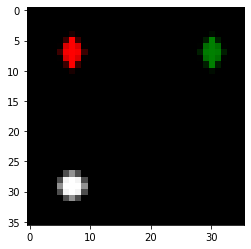

In [20]:
env = PointEnvGrid()
print(env.reset(agent_pos=[3], obj_pos=[0,1], obj_colors=[0,1], obj_shapes=[3], scalar=5))
#plt.imshow(plot_env(env))
state = plot_full_state(env.get_full_obs())
plt.imshow(state)
img, img_mask = plot_img_mask(env.get_full_obs())
img_mask = img_mask.reshape((36, 36, 1)) #reshape to 1 channel
img_mask = np.repeat(img_mask, 3, axis=2)
masked_img = img * img_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


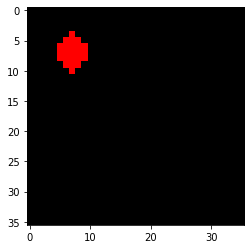

In [21]:
plt.imshow(masked_img)

In [109]:
# generates random trajs within specified constraints
def gen_trajs(env, num_trajs=1, agent_pos=[0,1,2,3], obj_pos=[0,1,2,3], obj_colors=[0,1,2,3], obj_shapes=[0,1,2,3], scalar=5):
    trajs = []
    for traj in range(num_trajs):
        env.reset(agent_pos=agent_pos, obj_pos=obj_pos, obj_colors=obj_colors, obj_shapes=obj_shapes, scalar=scalar)
        #plt.imshow(plot_env(env))
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [],'goal': [], 'gt_masks': []}
        delta_vector = env.goal_pos - env.pos
        obs = plot_full_state(env.get_full_obs())
        for i in range(20):
            _, img_mask = plot_img_mask(env.get_full_obs())
            act = delta_vector * 0.05 # Go in direction between start and end
            traj['obs'].append(obs.copy())
            traj['acts'].append(act.copy())
            one_hot_goal = np.concatenate([env.goal_color, env.goal_shape])
            traj['goal'].append(one_hot_goal)
            traj['gt_masks'].append(img_mask)
            no, r, d, _ = env.step(act)
            obs = plot_full_state(no.copy())
        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['goal'] = np.array(traj['goal'])
        traj['gt_masks'] = np.array(traj['gt_masks'])
        #plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
        trajs.append(traj)
    return trajs

In [110]:
# colors = RGBY
# shapes = Xs^d (star, square, triangle, diamond)
env = PointEnvGrid()
trajs = gen_trajs(env, num_trajs=100, agent_pos=[2,3], obj_pos=[0,1], obj_colors=[1,2], obj_shapes=[3], scalar=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


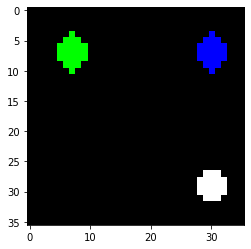

In [111]:
#import seaborn as sns
step = 0
traj = 0
state = trajs[traj]['obs'][step]
gt_mask = trajs[traj]['gt_masks'][step]
plt.imshow(gt_mask)
gt_mask = gt_mask.reshape((36, 36, 1))
gt_mask = np.repeat(gt_mask, 3, axis=2) # duplicate across 3 channels
final_state = state * gt_mask # apply mask to full state
plt.imshow(final_state)

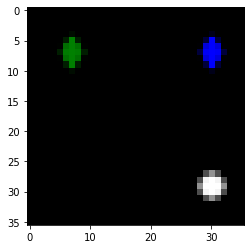

In [112]:
plt.imshow(trajs[traj]['obs'][step])

In [113]:
num_tasks = len(trajs)

goal_size = 8 #384
env = PointEnvGrid()
act_size = env.action_space.shape[0]
hidden_size = 100
mask = True

policy = CNNPolicy(goal_size, act_size, hidden_size, mask=mask)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

CNNPolicy(
  (goal): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
  )
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Flatten()
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=32, out_features=100, bias=True)
  )
  (process): Sequential(
    (0): Linear(in_features=200, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1296, bias=True)
    (3): Sigmoid()
  )
  (cnntrunk): Sequential(
    (0): Conv2

[1,     1] loss: 1.42300904
[1,     1] mask loss: 0.00727538
[1,     1] action loss: 1.41573370
[2,     1] loss: 0.93119633
[2,     1] mask loss: 0.00690640
[2,     1] action loss: 0.92428994
[3,     1] loss: 0.89260715
[3,     1] mask loss: 0.00710993
[3,     1] action loss: 0.88549721
[4,     1] loss: 0.79282182
[4,     1] mask loss: 0.00701190
[4,     1] action loss: 0.78580993
[5,     1] loss: 0.62305653
[5,     1] mask loss: 0.00722804
[5,     1] action loss: 0.61582851
[6,     1] loss: 0.62072295
[6,     1] mask loss: 0.00715290
[6,     1] action loss: 0.61357003
[7,     1] loss: 0.55696797
[7,     1] mask loss: 0.00737379
[7,     1] action loss: 0.54959416
[8,     1] loss: 0.58487082
[8,     1] mask loss: 0.00691907
[8,     1] action loss: 0.57795173
[9,     1] loss: 0.49285033
[9,     1] mask loss: 0.00702136
[9,     1] action loss: 0.48582897
[10,     1] loss: 0.48845154
[10,     1] mask loss: 0.00714026
[10,     1] action loss: 0.48131129
[11,     1] loss: 0.48164758
[11,    

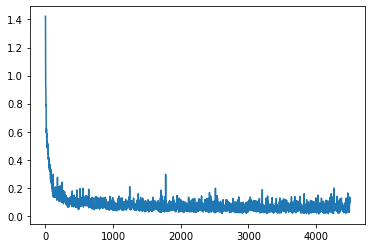

In [114]:
num_epochs = 1500
batch_size = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()))

losses = []

idxs = np.array(range(len(trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t_idx = np.random.randint(len(trajs), size=(batch_size,)) # Indices of traj
        t_idx_pertraj = np.random.randint(20, size=(batch_size,)) # Indices of timesteps in traj
        t_states = np.concatenate([trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_goals = np.concatenate([trajs[c_idx]['goal'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_gt_masks = np.concatenate([trajs[c_idx]['gt_masks'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_actions = np.concatenate([trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
   
        t_states = torch.Tensor(t_states).float().to(device)
        t_goals = torch.Tensor(t_goals).float().to(device)
        #t_goals = torch.Tensor(lang_model.encode(t_goals.ravel())).float().to(device) # embeds goal through language model dim:384
        t_gt_masks = torch.Tensor(t_gt_masks).float().to(device)
        t_actions = torch.Tensor(t_actions).float().to(device)
        
        if mask:
            a_preds, masked_state_preds, img_mask_preds = policy(t_goals, t_states, t_gt_masks)
            mask_loss = 5e-6*masked_state_preds.sum()
        else:
            a_preds = policy(t_goals, t_states, t_gt_masks)[0]
        
        action_loss = torch.mean(torch.linalg.norm(a_preds - t_actions, dim=-1)) # supervised learning loss
        #construal_loss = 1e-1*((state_mask_preds - t_construals)*(state_mask_preds - t_construals)).sum() # MSE supervised construal loss
        if mask:
            loss = action_loss + mask_loss
        else:
            loss = action_loss
            mask_loss = 0
        
        loss.backward()
        #print(policy.conv[0].weight.grad)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            print('[%d, %5d] mask loss: %.8f' %
                  (epoch + 1, i + 1, mask_loss))
            print('[%d, %5d] action loss: %.8f' %
                  (epoch + 1, i + 1, action_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

['go to the green d']
Average dist to goal:  -0.5333497124562009
Average std:  0.0


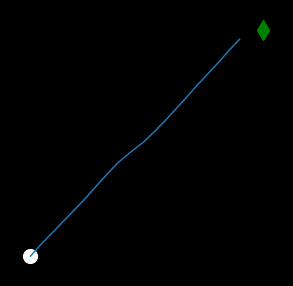

In [151]:
policy.eval()
num_test_trajs = 1
# sets sampling for angles and colors
agent_pos=[3]
obj_pos=[1,1,1]
obj_colors=[1]
obj_shapes=[3]
scalar=5

dist_to_goals = []

for i in range(num_test_trajs):
    env.reset(agent_pos, obj_pos, obj_colors, obj_shapes, scalar)
    one_hot_goal = np.concatenate([env.goal_color, env.goal_shape])
    goal = torch.Tensor(one_hot_goal[None]).to(device)
    #goal = torch.Tensor(lang_model.encode(env.goal)).to(device)
    obs = plot_full_state(env.get_full_obs())
    _, gt_mask = plot_img_mask(env.get_full_obs())
    
    traj = {'obs': [],'acts': [], 'true_goal': [], 'agent_pos': [], 'masked_states': [], 'masks': []}
    for i in range(20):
        state = torch.Tensor(obs[None]).to(device)
        gt_mask = torch.Tensor(gt_mask[None]).to(device)
        if mask:
            action, masked_state, img_mask = policy(goal,state,gt_mask)
            action = action.cpu().detach().numpy()[0]
            masked_state = masked_state.cpu().detach().numpy()[0].transpose((1,2,0))
            img_mask = img_mask.cpu().detach().numpy()[0].transpose((1,2,0))
            traj['masked_states'].append(masked_state)
            traj['masks'].append(img_mask)
        else:
            action = policy(goal,state,gt_mask)[0].cpu().detach().numpy()[0]
        traj['obs'].append(obs.copy())
        traj['acts'].append(action.copy())
        traj['true_goal'].append(env.goal)
        traj['agent_pos'].append(env.pos.tolist())
        no, r, d, _ = env.step(action)
        obs = plot_full_state(env.get_full_obs())
        _, gt_mask = plot_img_mask(env.get_full_obs())
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['true_goal'] = np.array(traj['true_goal'])
    traj['agent_pos'] = np.array(traj['agent_pos'])
    traj['masked_states'] = np.array(traj['masked_states'])
    traj['masks'] = np.array(traj['masks'])
    dist_to_goals.append(r.copy())
    #print("Final dist to goal: ", r)
    fig = plt.figure(figsize=(5, 5),facecolor="black")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    colors = sns.color_palette("hls", 10)
    plt.scatter(traj['agent_pos'][0][0], traj['agent_pos'][0][1], marker='o', color='white', s=200) # plots obj1
    plt.scatter(env.obj1_pos[0], env.obj1_pos[1], marker=get_shape(env.obj1_shape), color=get_color(env.obj1_color), s=200) # plots obj1
    plt.scatter(env.obj2_pos[0], env.obj2_pos[1], marker=get_shape(env.obj2_shape), color=get_color(env.obj2_color), s=200) # plots obj1
    #plt.scatter(env.goal_pos[0], env.goal_pos[1], marker='X', color=get_color(env.goal_color), s=1000) # plots goal
    plt.plot(traj['agent_pos'][:, 0], traj['agent_pos'][:, 1]) # plots trajs
    plt.axis('off')
print(env.goal)
print("Average dist to goal: ", np.mean(dist_to_goals))
print("Average std: ", np.std(dist_to_goals))

['go to the green d']


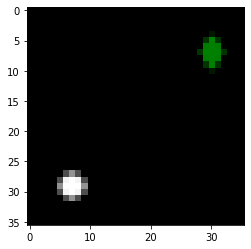

In [152]:
step = 0
print(traj['true_goal'][step])
state = traj['obs'][step].copy()
plt.imshow(state)

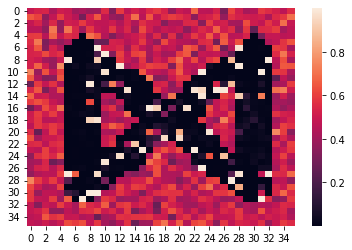

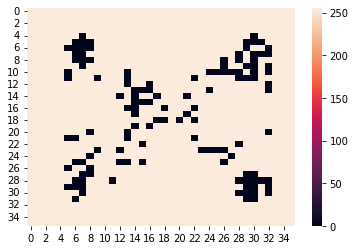

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


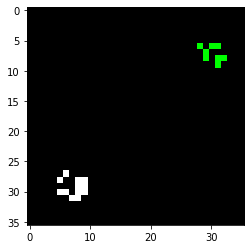

In [157]:
test_mask = traj['masks'][step].copy()
ax = sns.heatmap(test_mask[:,:,0])
plt.show()
threshold = 0.0012
test_mask[test_mask>threshold] = 255
test_mask[test_mask<=threshold] = 0
ax = sns.heatmap(test_mask[:,:,0])
plt.show()
masked_state = state * test_mask
#plt.imshow(traj['masked_states'][step])
plt.imshow(masked_state)

In [145]:
finetune_trajs1 = gen_trajs(env, num_trajs=5, agent_pos=[0,1,2,3], obj_pos=[0,1,2,3], obj_colors=[2,3], scalar=5)
finetune_trajs2 = gen_trajs(env, num_trajs=5, agent_pos=[0,1,2,3], obj_pos=[0,1,2,3], obj_colors=[2,3], scalar=5)
finetune_trajs = finetune_trajs1 + finetune_trajs2

In [ ]:
policy_copy = copy.deepcopy(policy)
num_epochs = 1000
batch_size = 50

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy_copy.parameters()))

losses = []

idxs = np.array(range(len(finetune_trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t_idx = np.random.randint(len(finetune_trajs), size=(batch_size,)) # Indices of traj
        t_idx_pertraj = np.random.randint(20, size=(batch_size,)) # Indices of timesteps in traj
        t_states = np.concatenate([finetune_trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_goals = np.concatenate([finetune_trajs[c_idx]['goal'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_gt_masks = np.concatenate([finetune_trajs[c_idx]['gt_masks'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        t_actions = np.concatenate([finetune_trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
   
        t_states = torch.Tensor(t_states).float().to(device)
        t_goals = torch.Tensor(t_goals).float().to(device)
        #t_goals = torch.Tensor(lang_model.encode(t_goals.ravel())).float().to(device) # embeds goal through language model dim:384
        t_gt_masks = torch.Tensor(t_gt_masks).float().to(device)
        t_actions = torch.Tensor(t_actions).float().to(device)
        
        if mask:
            a_preds, masked_state_preds, img_mask_preds = policy_copy(t_goals, t_states, t_gt_masks)
            mask_loss = 5e-6*masked_state_preds.sum()
        else:
            a_preds = policy_copy(t_goals, t_states, t_gt_masks)[0]
        
        action_loss = torch.mean(torch.linalg.norm(a_preds - t_actions, dim=-1)) # supervised learning loss
        #construal_loss = 1e-1*((state_mask_preds - t_construals)*(state_mask_preds - t_construals)).sum() # MSE supervised construal loss
        if mask:
            loss = action_loss + mask_loss
        else:
            loss = action_loss
            mask_loss = 0
        
        loss.backward()
        #print(policy_copy.conv[0].weight.grad)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            print('[%d, %5d] mask loss: %.8f' %
                  (epoch + 1, i + 1, mask_loss))
            print('[%d, %5d] action loss: %.8f' %
                  (epoch + 1, i + 1, action_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

In [ ]:
policy_copy.eval()
num_test_trajs = 20
# sets sampling for angles and colors
agent_pos=[2,3]
obj_pos=[0,1]
obj_colors=[0,1,2,3]
scalar=5

dist_to_goals = []

for i in range(num_test_trajs):
    env.reset(agent_pos, obj_pos, obj_colors, scalar)
    goal = torch.Tensor(env.goal_color[None]).to(device)
    #goal = torch.Tensor(lang_model.encode(env.goal)).to(device)
    obs = plot_full_state(env.get_full_obs())
    _, gt_mask = plot_img_mask(env.get_full_obs())
    
    traj = {'obs': [],'acts': [], 'true_goal': [], 'agent_pos': [], 'masked_states': [], 'masks': []}
    for i in range(20):
        state = torch.Tensor(obs[None]).to(device)
        gt_mask = torch.Tensor(gt_mask[None]).to(device)
        if mask:
            action, masked_state, img_mask = policy_copy(goal,state,gt_mask)
            action = action.cpu().detach().numpy()[0]
            masked_state = masked_state.cpu().detach().numpy()[0].transpose((1,2,0))
            img_mask = img_mask.cpu().detach().numpy()[0].transpose((1,2,0))
            traj['masked_states'].append(masked_state)
            traj['masks'].append(img_mask)
        else:
            action = policy_copy(goal,state,gt_mask)[0].cpu().detach().numpy()[0]
        traj['obs'].append(obs.copy())
        traj['acts'].append(action.copy())
        traj['true_goal'].append(env.goal)
        traj['agent_pos'].append(env.pos.tolist())
        no, r, d, _ = env.step(action)
        obs = plot_full_state(env.get_full_obs())
        _, gt_mask = plot_img_mask(env.get_full_obs())
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['true_goal'] = np.array(traj['true_goal'])
    traj['agent_pos'] = np.array(traj['agent_pos'])
    traj['masked_states'] = np.array(traj['masked_states'])
    traj['masks'] = np.array(traj['masks'])
    dist_to_goals.append(r.copy())
    #print("Final dist to goal: ", r)
    fig = plt.figure(figsize=(5, 5),facecolor="black")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    colors = sns.color_palette("hls", 10)
    plt.scatter(traj['agent_pos'][0][0], traj['agent_pos'][0][1], marker='v', color='white', s=200) # plots obj1
    plt.scatter(env.obj1_pos[0], env.obj1_pos[1], marker='s', color=get_color(env.obj1_color), s=150) # plots obj1
    plt.scatter(env.obj2_pos[0], env.obj2_pos[1], marker='s', color=get_color(env.obj2_color), s=150) # plots obj1
    plt.scatter(env.goal_pos[0], env.goal_pos[1], marker='X', color=get_color(env.goal_color), s=1000) # plots goal
    plt.plot(traj['agent_pos'][:, 0], traj['agent_pos'][:, 1]) # plots trajs
    plt.axis('off')
print("Average dist to goal: ", np.mean(dist_to_goals))
print("Average std: ", np.std(dist_to_goals))